In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [115]:
#Import data
data_for_training = "../../../data/Data_For_Training/"
data = pd.read_csv(data_for_training + "icfes_20141_nn_em.csv")
data = data.set_index("Unnamed: 0")

In [116]:
resultados = [ 'DESEMP_INGLES', 'PUNT_MATEMATICAS', 'PUNT_CIENCIAS_SOCIALES', 
            'PUNT_INGLES','PUNT_BIOLOGIA', 'PUNT_FILOSOFIA',
 'PUNT_FISICA', 'PUNT_QUIMICA', 'PUNT_LENGUAJE', 'RECAF_PUNT_SOCIALES_CIUDADANAS',
 'RECAF_PUNT_INGLES', 'RECAF_PUNT_LECTURA_CRITICA', 'RECAF_PUNT_MATEMATICAS',
 'RECAF_PUNT_C_NATURALES', 'ESTU_PUESTO', 
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_CIENCIAS_SOCIALES',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_BIOLOGIA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_FILOSOFIA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_FISICA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_QUIMICA',
 'NOTA_Z_COLE_CODIGO_ICFES_PUNT_LENGUAJE',
 'NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO',
 'DECILE_PUNT_MATEMATICAS', 'DECILE_PUNT_CIENCIAS_SOCIALES',
 'DECILE_PUNT_INGLES', 'DECILE_PUNT_BIOLOGIA',
 'DECILE_PUNT_FILOSOFIA', 'DECILE_PUNT_FISICA',
 'DECILE_PUNT_QUIMICA', 'DECILE_PUNT_LENGUAJE',
 'DECILE_ESTU_PUESTO']

data_results = data[resultados]
data_features = data.drop(resultados,axis=1)
data_features.shape

(20890, 202)

In [44]:
data_results.DESEMP_INGLES.value_counts()

1.0    7733
2.0    4312
5.0    4121
4.0    3105
3.0    1619
Name: DESEMP_INGLES, dtype: int64

In [25]:
#normalizamos los datos
scaler=StandardScaler()
scaler.fit(data_features) # calculo la media para poder hacer la transformacion
data_features_scaled=scaler.transform(data_features)# Ahora si, escalo los datos y los normalizo

## PCA

In [28]:
#features_pca=pca.transform(data_features_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA
threshold = 0.8
explained_variance = []
amount_of_components = []
for k in range(data_features.shape[1]//10):
    print("Cantidad de componentes ", k*10)
    pca=PCA(n_components=k*10) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
    pca.fit(data_features_scaled) # obtener los componentes principales
    amount_of_components.append(k*10)
    explained_variance.append(sum(pca.explained_variance_ratio_))
    if sum(pca.explained_variance_ratio_) > threshold:
        break

Cantidad de componentes  0
Cantidad de componentes  10
Cantidad de componentes  20
Cantidad de componentes  30
Cantidad de componentes  40
Cantidad de componentes  50
Cantidad de componentes  60
Cantidad de componentes  70
Cantidad de componentes  80
Cantidad de componentes  90
Cantidad de componentes  100
Cantidad de componentes  110
Cantidad de componentes  120
Cantidad de componentes  130
Cantidad de componentes  140
Cantidad de componentes  150
Cantidad de componentes  160
Cantidad de componentes  170
Cantidad de componentes  180
Cantidad de componentes  190


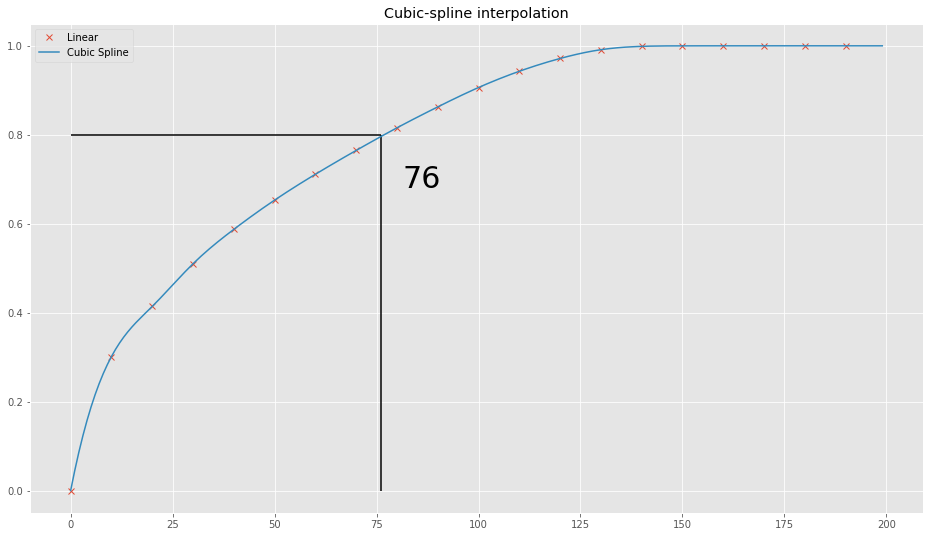

In [88]:
from scipy import interpolate
from scipy.optimize import fsolve
from functools import partial

tck = interpolate.splrep(amount_of_components,explained_variance, s=0)
xnew = np.arange(0, 200, 1)
ynew = interpolate.splev(xnew, tck, der=0)

def f(x,value,tck):
    return interpolate.splev(x,tck,der=0)-value

starting_guess = 100
pca_comp = int(fsolve(partial(f,value=threshold,tck=tck),starting_guess))
plt.figure()
plt.text(pca_comp+10, threshold-0.1, str(pca_comp), horizontalalignment='center',
      verticalalignment='center',fontsize=30)
plt.hlines(threshold,0,pca_comp)
plt.vlines(pca_comp,0,threshold)
plt.plot(amount_of_components,explained_variance, 'x', xnew, ynew)
plt.legend(['Linear', 'Cubic Spline'])
plt.title('Cubic-spline interpolation')
plt.show()


In [90]:
print("Una primer anzats para la cantidad óptima de variables a utilizar es ",pca_comp, 
      " pues usando PCA se logra reproducir un ",threshold*100,"% de la varianza de los datos")

Una primer anzats para la cantidad óptima de variables a utilizar es  76  pues usando PCA se logra reproducir un  80.0 % de la varianza de los datos


## UMAP

In [37]:
import umap
import umap.plot
import pickle

In [117]:
reducer = umap.UMAP(n_neighbors=30,min_dist=0.3, n_components=pca_comp,metric='correlation').fit(data_features)

f_name = '2014_1_nn_mice_'+str(pca_comp)+'.umap'
pickle.dump(reducer, open(f_name, 'wb'))

# time passes
#loaded_model = pickle.load((open(f_name, 'rb')))
#print(type(loaded_model))
# <class 'umap.umap_.UMAP'>


In [105]:
cols = []
for i in range(pca_comp):
    cols.append("feature_"+str(i))
cols = cols + data_results.columns.to_list()    
data_transformed = pd.DataFrame(data=np.concatenate((reducer.embedding_,
                  data_results.values),axis=1),columns=cols)

name = '2014_1_nn_mice_'+str(pca_comp)+'.csv'
data_transformed.to_csv(data_for_training+name)


In [106]:
data_transformed

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      13.781266   6.432945   6.876776   5.800756   6.654003   7.047012   
1      11.486050   7.684496   3.302598   4.521889   3.013833   6.671743   
2      13.464535   4.693771   5.850790   7.339652   3.944598   6.122334   
3       6.113369  15.231881   7.505983   6.120226   6.091174   5.373609   
4      13.381559   7.318180   6.650201   4.372172   6.997713   4.483925   
...          ...        ...        ...        ...        ...        ...   
20885  10.501165   6.199299   3.821108   7.134315   5.984504   4.794294   
20886   9.592625   5.059600   5.181601   5.434444   5.449584   4.389914   
20887   8.787493   2.874129   6.642263   2.464152   2.154570   6.599435   
20888  13.127875   3.811864   4.167008   6.377601   3.046281   2.281858   
20889  10.554919   6.157213   3.929816   7.111351   6.073596   4.666568   

       feature_6  feature_7  feature_8  feature_9  ...  \
0       5.959054   7.552651   4.826524   6.432781  ...   
1       4.144600   7.283816   5.667122   6.188894  ...   
2       2.901156   4.129673   5.076660   3.458340  ...   
3       4.983725   5.730417   5.309866   5.081767  ...   
4       7.172759   5.976661   6.837384   5.793393  ...   
...          ...        ...        ...        ...  ...   
20885   5.484200   4.281426   3.820207   5.728920  ...   
20886   4.090785   6.534019   5.981760   3.986061  ...   
20887   6.202354   3.744259   4.203580   5.855135  ...   
20888   5.640383   5.317501   6.161222   6.358976  ...   
20889   5.275630   4.410184   3.866159   5.847751  ...   

       NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO  DECILE_PUNT_MATEMATICAS  \
0                                  0.063367                    909.0   
1                                  2.613955                    514.0   
2                                 -0.223216                    751.0   
3                                 -0.739066                    981.0   
4                                 -0.844146                    957.0   
...                                     ...                      ...   
20885                              0.086085                    219.0   
20886                              0.455018                     69.0   
20887                              0.561087                    117.0   
20888                             -0.582608                    314.0   
20889                              0.685602                     30.0   

       DECILE_PUNT_CIENCIAS_SOCIALES  DECILE_PUNT_INGLES  \
0                              828.0               715.0   
1                              327.0               759.0   
2                              848.0               971.0   
3                              960.0               932.0   
4                              914.0               927.0   
...                              ...                 ...   
20885                          240.0               155.0   
20886                          413.0               256.0   
20887                          303.0                66.0   
20888                          193.0               209.0   
20889                          115.0               255.0   

       DECILE_PUNT_BIOLOGIA  DECILE_PUNT_FILOSOFIA  DECILE_PUNT_FISICA  \
0                     633.0                  508.0               643.0   
1                     452.0                  385.0               712.0   
2                     973.0                  510.0               956.0   
3                     951.0                  833.0               989.0   
4                     881.0                  666.0               980.0   
...                     ...                    ...                 ...   
20885                 492.0                  125.0               592.0   
20886                 105.0                  359.0               145.0   
20887                 221.0                  350.0               138.0   
20888                 563.0                  666.0               279.0   
20889    

In [118]:
mapper_trained = umap.UMAP(n_neighbors=30,min_dist=0.3).fit(data_features,y=data_results.DESEMP_INGLES)

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-u_M2eJSI/lib/python3.6/site-packages/umap/spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
/home/trucupey/.virtualenvs/ICFES-SocioEconomico-u_M2eJSI/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


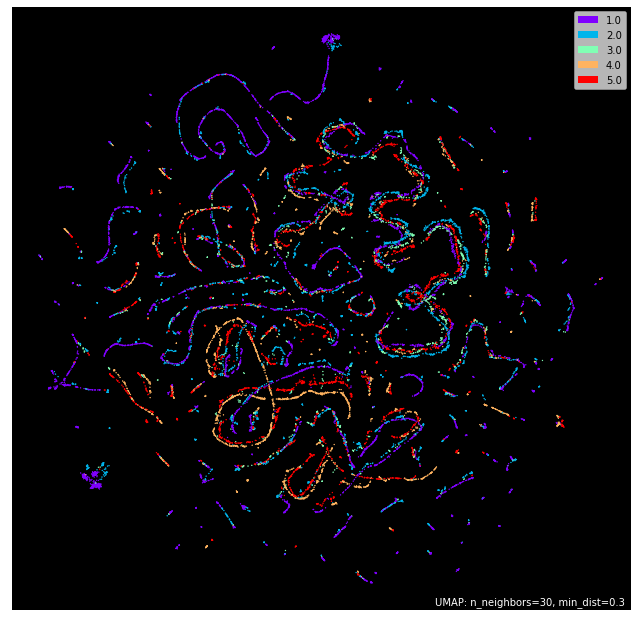

In [119]:
umap.plot.points(mapper_trained,labels=data_results.DESEMP_INGLES,theme='fire')

In [120]:
mapper = umap.UMAP(n_neighbors=30,min_dist=0.3).fit(data_features)

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-u_M2eJSI/lib/python3.6/site-packages/umap/spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
/home/trucupey/.virtualenvs/ICFES-SocioEconomico-u_M2eJSI/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


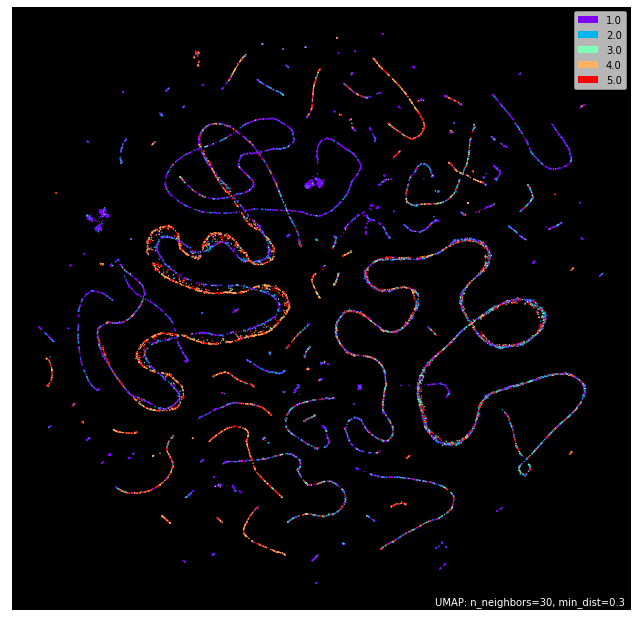

In [121]:
umap.plot.points(mapper,labels=data_results.DESEMP_INGLES,theme='fire')